# NLP Project with Women's E-Commerce Clothing Reviews

# Getting started <a class="anchor" id="getting_started"></a>

The objective of this analysis is to understand what customers like and dislike about the clothing products, mainly by using natural language processing (NLP) to disaggregate their product reviews. Age of the reviewer is also explored for predictive value of product recommendation. The analysis also aims to uncover topics of reviews for those that recommend and don't recommend the product (topic modeling). The bottom of the analysis includes a binary classification model that predicts whether the reviewer recommends the product based on what they wrote in their review.

What other natural language processing techniques could be employed on the product reviews to understand what customers think about the products? How would you approach the analysis objective? I'd love to hear other people's thoughts.

-Mason

In [1]:
# Measure how long it takes to run the notebook
from datetime import datetime, timedelta

start = datetime.now()
print('Start time:', start)

In [2]:
# Working with dataframes and arrays
import pandas as pd
import numpy as np
import math

# Ploting
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim import corpora

# Modeling
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mlxtend.preprocessing import DenseTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score

# Cleaner notebook
import warnings 
warnings.filterwarnings("ignore")

# Notebook settings
stop_words = set(stopwords.words('english'))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Link to dataset
# https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

In [4]:
# Description of fields:

# Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
# Age: Positive Integer variable of the reviewers age.
# Title: String variable for the title of the review.
# Review Text: String variable for the review body.
# Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
# Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
# Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
# Division Name: Categorical name of the product high level division.
# Department Name: Categorical name of the product department name.
# Class Name: Categorical name of the product class name.

In [5]:
# Read and preview data
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
print(df.shape)
print(df.columns)
df.head()

(23486, 11)
Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


# Data preprocessing

In [6]:
# Remove the column: 'Unnamed: 0'
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
# Count the number of nulls in each column
df.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [8]:
# Count the number of unique values in each column
df.nunique()

Clothing ID                 1206
Age                           77
Title                      13993
Review Text                22634
Rating                         5
Recommended IND                2
Positive Feedback Count       82
Division Name                  3
Department Name                6
Class Name                    20
dtype: int64

In [9]:
# Clean text data (remove special characters, lowercase, remove stop words, and lemmatize)

# I found this function for text preprocessing online. I think it was towardsdatascience.com,
# but I can't find/remember where I found it. If I find the site, I'll post the source to give the author credit.

def preprocess(raw_text):
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = WordNetLemmatizer()

    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    lemmas = []
    for word in cleaned_words:
        word = lemmatizer.lemmatize(word)
        lemmas.append(word)
    
    return " ".join(lemmas)

df['Review Text'] = df['Review Text'].astype(str)
df['clean_review_text'] = df['Review Text'].apply(preprocess)

# Inspect the cleaned text data
df[['Review Text','clean_review_text']].head(3)

,Review Text,clean_review_text
0,Absolutely wonderful - silky and sexy and comfortable,absolutely wonderful silky sexy comfortable
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",love dress sooo pretty happened find store glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite
2,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c


# Exploratory data analysis

## Product polarity
Customer's give the product a rating (1 Worst, to 5 Best). We'll use the rating to find if there polarizing products or products overwhelmingly liked or disliked. Filter out products with less than 30 reviews. Net Polarity = (% 4 and 5 star ratings) - (% 1 and 2 star ratings).

The higher the net polarity the more universally liked the product is. A net polarity score of 0 means the product is completely polar, and less than 0 is more disliked than liked.

Text(0.5, 1.0, 'Distribution of Product Net Polarity')

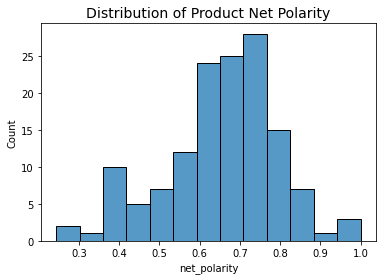

In [10]:
# Count number of reviews for each product by rating
df_ratings = df.pivot_table(values='Review Text'
                            , index='Clothing ID'
                            , columns='Rating'
                            , aggfunc='count'
                            , margins=True
                            , margins_name='Total'
                            , fill_value=0)

# Use the percent of 1 and 2, and 4 and 5 star reviews to gauge if there are polarizing product
df_ratings['percent_5_star'] = (df_ratings[5] + df_ratings[4]) / df_ratings['Total']
df_ratings['percent_1_star'] = (df_ratings[1] + df_ratings[2]) / df_ratings['Total']
df_ratings['net_polarity'] = df_ratings['percent_5_star'] - df_ratings['percent_1_star']

# Filter out products with less than 30 reviews
df_ratings = df_ratings[df_ratings['Total'] >= 30]

# Distribution of product net polarity
sns.histplot(df_ratings['net_polarity'])
plt.title('Distribution of Product Net Polarity', fontsize=14)

## Ratings
Plot the distribution of the ratings by whether the product was recommended.

One interesting thing from the plots is that most of the people that did not recommend the product gave it a rating of 3.

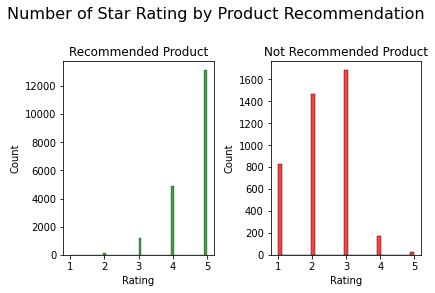

In [11]:
# Distribution of star ratings by whehter the reviewer recommends the product
recommended = df[df['Recommended IND'] == 1]
not_recommended = df[df['Recommended IND'] == 0]

plt.subplot(1, 2, 1)
sns.histplot(recommended['Rating'], color='green')
plt.title('Recommended Product')

plt.subplot(1, 2, 2)
sns.histplot(not_recommended['Rating'], color='red')
plt.title('Not Recommended Product')
plt.suptitle('Number of Star Rating by Product Recommendation', fontsize=16, verticalalignment='center', horizontalalignment='center')
plt.tight_layout()
plt.show()

## Number of characters and words in the review
There's not a big difference in the number of words and characters a review contains whether they do or don't recommend the product.

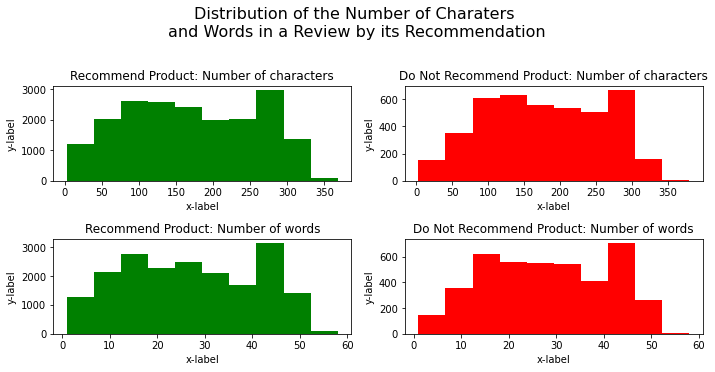

In [12]:
# Number of characters in the review by whehter the reviewer recommends the product
df['num_characters'] = df['clean_review_text'].apply(len)

# Number of words in the review by whehter the reviewer recommends the product
df['num_words'] = [len(x.split()) for x in df['clean_review_text'].tolist()]

# Separate reviews that recommend and don't recommend the productd
recommend = df[df['Recommended IND'] == 1]
not_recommend = df[df['Recommended IND'] == 0]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(10,5))

axs[0, 0].hist(recommend['num_characters'], color='green')
axs[0, 0].set_title('Recommend Product: Number of characters')

axs[0, 1].hist(not_recommend['num_characters'], color='red')
axs[0, 1].set_title('Do Not Recommend Product: Number of characters')

axs[1, 0].hist(recommend['num_words'], color='green')
axs[1, 0].set_title('Recommend Product: Number of words')

axs[1, 1].hist(not_recommend['num_words'], color='red')
axs[1, 1].set_title('Do Not Recommend Product: Number of words')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

plt.suptitle('Distribution of the Number of Charaters \nand Words in a Review by its Recommendation', fontsize=16, verticalalignment='center', horizontalalignment='center')
fig.tight_layout()

## Age of reviewer

- Is age a good predictor of their rating and recommendation?
- What is the average rating for each age group?
- Do most of the 1 star ratings come from a specific age group, 2 star, etc.?

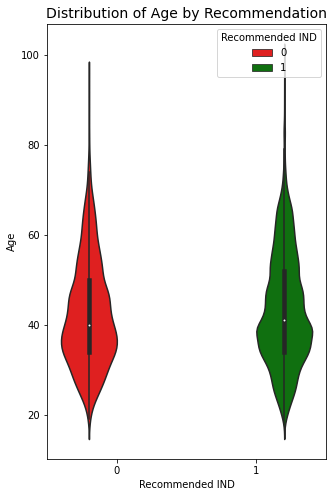

In [13]:
# Distribution of Age by Recommendation
# Not a big difference in age between those that recommend and don't recommend the product
plt.figure(figsize=(5,8))
sns.violinplot(y='Age', x='Recommended IND', hue='Recommended IND', data=df, palette=['red', 'green'])
plt.title('Distribution of Age by Recommendation', fontsize=14)
plt.show()

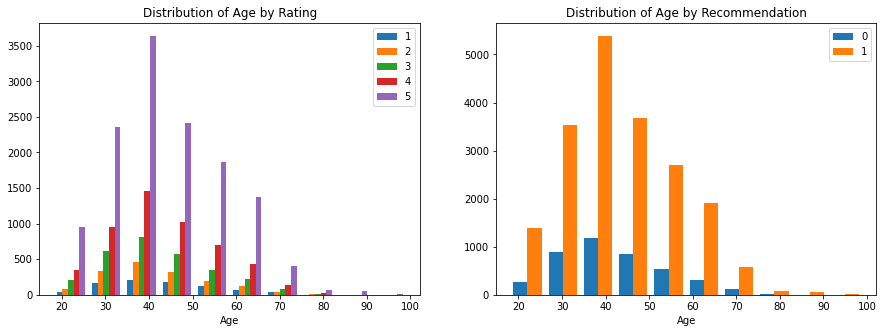

In [14]:
# Each age group has a similar range of ratings and recommendations given.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
n_bins = 10

ratings = sorted(list(df.Rating.unique()))
x1 = [df[df.Rating == i]['Age'].to_numpy() for i in ratings]
ax1.hist(x1, n_bins, histtype='bar')
ax1.set_xlabel('Age')
ax1.legend(ratings)
ax1.set_title('Distribution of Age by Rating', fontsize=12)

rec = sorted(list(df['Recommended IND'].unique()))
x2 = [df[df['Recommended IND'] == i]['Age'].to_numpy() for i in rec]
ax2.hist(x2, n_bins, histtype='bar')
ax2.set_xlabel('Age')
ax2.legend(rec)
ax2.set_title('Distribution of Age by Recommendation', fontsize=12)

plt.show()

In [15]:
# Binning age
age_bins = pd.qcut(df['Age'], q=6).rename('age_bins')
df = pd.concat([df, age_bins], axis=1)
df.age_bins.value_counts()

(17.999, 32.0]    4538
(41.0, 48.0]      4279
(32.0, 37.0]      4046
(56.0, 99.0]      3739
(48.0, 56.0]      3477
(37.0, 41.0]      3407
Name: age_bins, dtype: int64

In [16]:
# Average rating for each age group
# The oldest age group (56 to 99 yo) has the highest average rating, but all age groups have pretty similar average ratings.
(df.groupby('age_bins')
 .agg({'Rating': 'mean', 'clean_review_text': 'count'})
 .reset_index()
 .rename(columns={'Rating': 'Average_Rating', 'clean_review_text': 'Num_reviews', 'age_bins': 'Age Groups'})
 .style.background_gradient(cmap = 'YlGn')
 .format({'Average_Rating':'{:.2f}', 'Num_reviews': '{:.0f}'}))

,Age Groups,Average_Rating,Num_reviews
0,"(17.999, 32.0]",4.19,4538
1,"(32.0, 37.0]",4.15,4046
2,"(37.0, 41.0]",4.21,3407
3,"(41.0, 48.0]",4.14,4279
4,"(48.0, 56.0]",4.22,3477
5,"(56.0, 99.0]",4.28,3739


In [17]:
# Percent of ratings that come from each age group

# Most of the 1 ratings (worst) come from the 41 to 48 age group
# Most of the 5 ratings (best) come from the 56 to 99 age group
age_ratings = pd.pivot_table(data = df
              , values = 'clean_review_text'
              , index = 'age_bins'
              , columns = 'Rating'
              , aggfunc = 'count'
              , fill_value = 0
              , margins = True)

# Percent of column total
age_ratings_pct_col = age_ratings.copy()
for i in age_ratings.columns:
    age_ratings_pct_col[i] = age_ratings[i] / age_ratings.iloc[-1][i]

print('Percent of ratings that come from each age group')
rounded = dict()
for i in age_ratings_pct_col.columns:
    rounded[i] = "{:.2f}" # create a dictionary to format the decimals 

age_ratings_pct_col.style.background_gradient(axis=1, cmap = 'YlGn').format(rounded)

Percent of ratings that come from each age group


Rating,1,2,3,4,5,All
age_bins,,,,,,
"(17.999, 32.0]",0.19,0.18,0.21,0.19,0.19,0.19
"(32.0, 37.0]",0.17,0.21,0.18,0.17,0.17,0.17
"(37.0, 41.0]",0.12,0.13,0.14,0.16,0.14,0.15
"(41.0, 48.0]",0.21,0.21,0.18,0.19,0.17,0.18
"(48.0, 56.0]",0.14,0.13,0.14,0.15,0.15,0.15
"(56.0, 99.0]",0.17,0.13,0.13,0.14,0.17,0.16
All,1.00,1.00,1.00,1.00,1.00,1.00


# Natural language processing

## Frequent ngrams by recommendation
Find the 20 most common unigrams, bigrams, and trigrams used in reviews, and separate them by whether they recommend the product.

* Terms like "fit well", "true fit", and "fit perfectly" are common in reviews that recommend the product.

* Terms like "run small", "sadly going back", and "first time wore" are common in reviews that don't recommend the product.

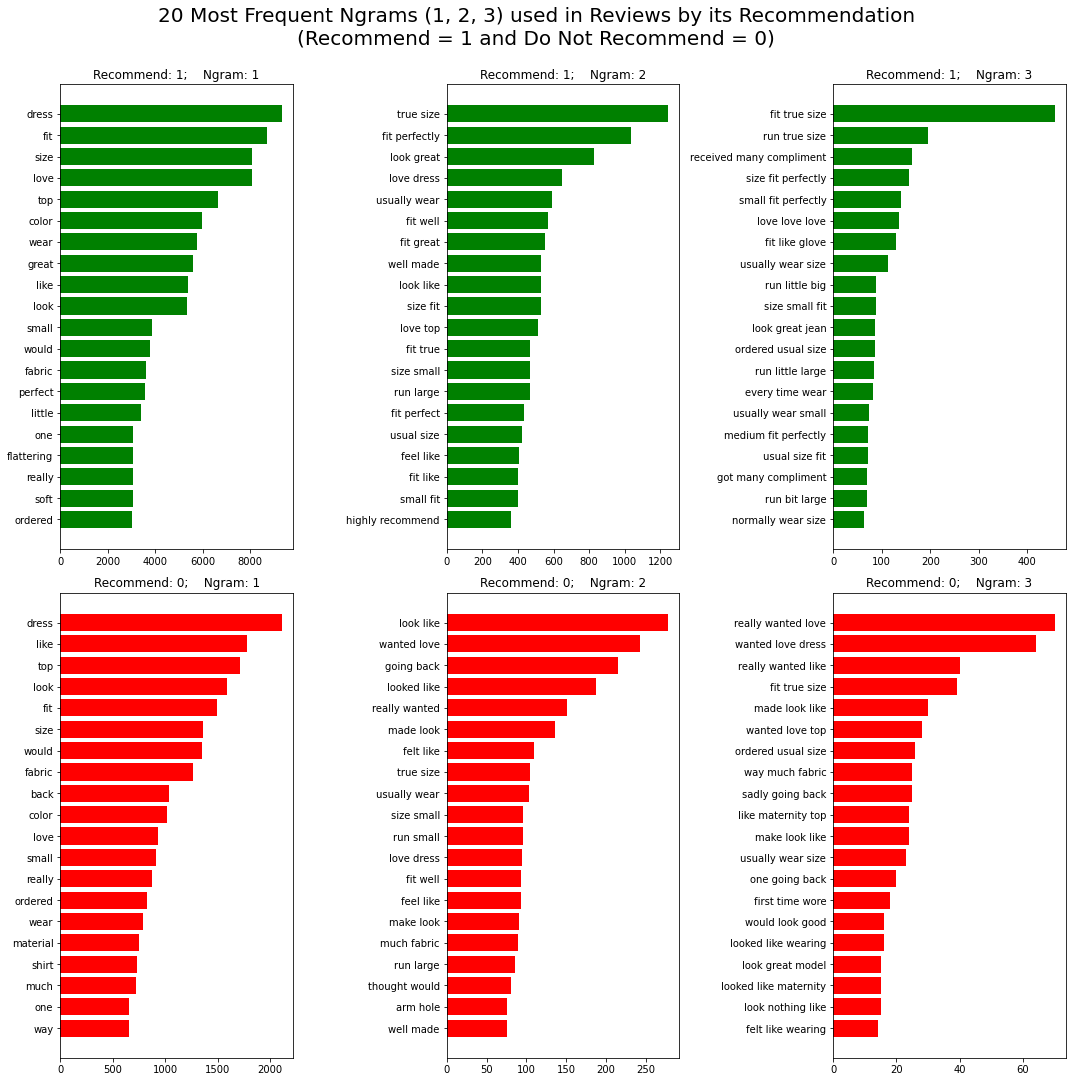

In [18]:
# Store ngrams for reviews that recommend and don't recommend the product in a dictionary
ngrams_dict = dict()

for i in sorted(df['Recommended IND'].unique(), reverse=True):
    X = df[df['Recommended IND'] == i]['clean_review_text']
    for n in range(1, 4):
        vectorizer = CountVectorizer(max_features = 20, ngram_range = (n,n))
        DTM = vectorizer.fit_transform(X)
        frequencies = sum(DTM).toarray()[0]
        ngrams = pd.DataFrame(frequencies, index = vectorizer.get_feature_names(), columns = ['Frequency'])
        ngrams.sort_values('Frequency', ascending = False, inplace=True)
        ngrams = ngrams.reset_index().rename(columns={'index':'Term'})
        ngrams['ngram'] = n
        ngrams['recommend'] = i
        ngrams_dict[str(i) + '_' + str(n)] = ngrams

# Plot ngrams by recommendation
fig = plt.figure(figsize = (15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, j in enumerate(list(ngrams_dict.keys())):
    i = i + 1
    to_plot = ngrams_dict[j]
    to_plot.sort_values('Frequency', inplace=True)
    not_rec_keys = ['0_1', '0_2', '0_3']
    if j in not_rec_keys:
        ax = fig.add_subplot(2, 3, i)
        ax.barh(to_plot.Term, to_plot.Frequency, color='red')
        ax.set_title("Recommend: " + str(j[:1]) + ";    Ngram: " + str(j[-1:]))
    else:
        ax = fig.add_subplot(2, 3, i)
        ax.barh(to_plot.Term, to_plot.Frequency, color='green')
        ax.set_title("Recommend: " + str(j[:1]) + ";    Ngram: " + str(j[-1:]))

for ax in axs.flat:
    ax.set(xlabel='Frequency', ylabel='Ngram')
plt.suptitle('20 Most Frequent Ngrams (1, 2, 3) used in Reviews by its Recommendation\n(Recommend = 1 and Do Not Recommend = 0)', fontsize=20, verticalalignment='center', horizontalalignment='center')
plt.tight_layout()
plt.show()

## Cosine similarity

Which product classes have the most similar and dissimilar reviews?
* Reviews for Dresses and Skirts are the most unique reviews (they are most dissimilar to reviews of other products)
* Reviews for Lounge are most similar to reviews for other products

In [19]:
# List of unique product classes
# Remove products with less than 10 reviews
class_reviews = df.groupby('Class Name').agg({'clean_review_text': 'nunique'})
classes = class_reviews[class_reviews.clean_review_text >= 10].index

# Use CountVectorizer to create a document term matrix (DTM) for each product's reviews
vectorizer = CountVectorizer()
DTM_clothes = pd.DataFrame()

# Create dictionary to store reviews for each product class
clothes_dict = dict()
for i,j in enumerate(classes):
    text = df[df['Class Name'] == j]['clean_review_text'] # filter dataframe for that product's reviews
    texts = str() # Create a string variable to store reviews
    for s,t in enumerate(text):
        if s == 0: # Necessary bc w/o enumerate (texts = texts + ' ' + t), it adds a spaces before the first review
            texts = t
        else:
            texts = texts + ' ' + t # put all of the reviews for each product together in a string
    bacon = list()
    bacon.append(texts) # put the string in a list
    clothes_dict[i] = bacon # Create a key in the dictionary to store the product reviews list
    DTM = (pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(bacon), columns=vectorizer.get_feature_names()) # Build document term matrix
             .transpose() # tranpose to move the terms to the index, it will make it easier when joining the DTMs
             .rename(columns={0: j})) # Name the column with the product class
    if i == 0:
        DTM_clothes = DTM
    else:
        DTM_clothes = DTM_clothes.join(DTM, how='outer') # put each product's DTM in a dataframe

DTM_clothes.fillna(0, inplace=True) # fill with 0 bc it was an outer join
DTM_clothes = DTM_clothes.transpose()

# Measure cosine similarity between the product reviews
cosine = pd.DataFrame(cosine_similarity(DTM_clothes), columns=DTM_clothes.index, index=DTM_clothes.index)
rounded = dict()
for i in cosine.columns:
    rounded[i] = "{:.2f}"

cosine.style.background_gradient(axis=1, cmap = 'YlGn').format(rounded)

,Blouses,Dresses,Fine gauge,Intimates,Jackets,Jeans,Knits,Layering,Legwear,Lounge,Outerwear,Pants,Shorts,Skirts,Sleep,Sweaters,Swim,Trend
Blouses,1.00,0.61,0.79,0.75,0.75,0.68,0.97,0.84,0.63,0.84,0.70,0.75,0.72,0.63,0.79,0.70,0.75,0.78
Dresses,0.61,1.00,0.61,0.60,0.63,0.54,0.62,0.62,0.54,0.80,0.59,0.61,0.58,0.53,0.68,0.56,0.55,0.87
Fine gauge,0.79,0.61,1.00,0.72,0.78,0.69,0.84,0.79,0.69,0.84,0.75,0.75,0.70,0.63,0.80,0.97,0.67,0.77
Intimates,0.75,0.60,0.72,1.00,0.72,0.66,0.78,0.80,0.65,0.82,0.68,0.73,0.69,0.60,0.79,0.67,0.74,0.72
Jackets,0.75,0.63,0.78,0.72,1.00,0.68,0.78,0.76,0.64,0.85,0.85,0.74,0.69,0.62,0.77,0.77,0.65,0.78
Jeans,0.68,0.54,0.69,0.66,0.68,1.00,0.69,0.67,0.65,0.75,0.63,0.80,0.68,0.57,0.72,0.64,0.61,0.68
Knits,0.97,0.62,0.84,0.78,0.78,0.69,1.00,0.88,0.68,0.87,0.71,0.77,0.74,0.63,0.82,0.75,0.74,0.78
Layering,0.84,0.62,0.79,0.80,0.76,0.67,0.88,1.00,0.68,0.86,0.71,0.75,0.71,0.62,0.79,0.72,0.70,0.74
Legwear,0.63,0.54,0.69,0.65,0.64,0.65,0.68,0.68,1.00,0.78,0.62,0.71,0.62,0.55,0.74,0.67,0.57,0.63
Lounge,0.84,0.80,0.84,0.82,0.85,0.75,0.87,0.86,0.78,1.00,0.79,0.86,0.78,0.66,0.92,0.79,0.74,0.88


In [20]:
# Find the most similar and dissimilar product reviews for each product class
sim = []
dis = []
for i in cosine.columns:
    spam = cosine.sort_values(i, ascending=False)
    eggs = spam.index[1] # the first value (index 0) will be itself so take the second highest value
    bacon = spam.index[-1]
    sim.append(eggs)
    dis.append(bacon)

sim_dis_reviews = pd.DataFrame({'Most_Similar': sim, 'Most_Dissimilar': dis}
                               , index = cosine.columns)

sim_dis_reviews

,Most_Similar,Most_Dissimilar
Blouses,Knits,Dresses
Dresses,Trend,Skirts
Fine gauge,Sweaters,Dresses
Intimates,Lounge,Skirts
Jackets,Outerwear,Skirts
Jeans,Pants,Dresses
Knits,Blouses,Dresses
Layering,Knits,Skirts
Legwear,Lounge,Dresses
Lounge,Sleep,Skirts


## Sentiment analysis
Use the nltk library to give each review a sentiment score from -1 (negative) to 1 (positive). Plot the distribution of the sentiment scores.

Text(0.5, 1.0, 'Sentiment of Review by Recommendation')

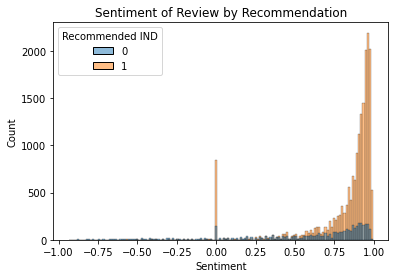

In [21]:
compound_sentiment = []
sentences = []
sid = SentimentIntensityAnalyzer()

for sentence in df['clean_review_text']:
    ss = sid.polarity_scores(sentence)
    compound_sentiment.append(ss['compound'])
    sentences.append(sentence)

sentiment_vader = pd.DataFrame({'Sentence': sentences,
                               'Sentiment': compound_sentiment})

df = pd.concat([df, sentiment_vader.Sentiment], axis=1)

sns.histplot(x='Sentiment', hue='Recommended IND', data=df)
plt.title('Sentiment of Review by Recommendation', fontsize=12)

## Model sentiment (most positive and negative words)
Code the sentiment scores to be either positive or negative, and fit a logisitic regression model to predict the coded sentiment using the text in the review. Convert the logit coefficients to probability, and find which terms have the highest probability of the review being positive or negative.

In [22]:
def code_sentiment(x):
    if x > 0.75:
        return 1
    else:
        return 0

text = df.clean_review_text
vectorizer = TfidfVectorizer(max_features = 300)
X = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(text), index=text.index, columns=vectorizer.get_feature_names())

y = df.Sentiment.apply(code_sentiment)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

clf = LogisticRegression(random_state=1, solver='liblinear').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy', accuracy_score(y_test, y_pred))
print('='*100)

params = pd.DataFrame({'Feature': X.columns
                     , 'Logit': clf.coef_[0]})

def logit_to_prob(x):
    return math.exp(x) / (1 + math.exp(x))

params['Probability'] = params['Logit'].apply(logit_to_prob)

params.sort_values('Probability', ascending=False, inplace=True)
pos = list(params.head(20).iloc[:,0])
neg = list(params.tail(20).iloc[:,0])

print('Most positive terms:')
print(pos)
print('='*100)
print('Most negative terms:')
print(neg)

Accuracy 0.8804495912806539
Most positive terms:
['love', 'great', 'perfect', 'fit', 'beautiful', 'super', 'comfortable', 'perfectly', 'gorgeous', 'loved', 'lovely', 'best', 'compliment', 'happy', 'nice', 'better', 'like', 'fun', 'pretty', 'kind']
Most negative terms:
['wide', 'thin', 'back', 'felt', 'sized', 'thing', 'looked', 'item', 'returned', 'returning', 'without', 'low', 'return', 'loose', 'worn', 'nan', 'cut', 'unfortunately', 'problem', 'disappointed']


## Most frequent words that follow and preceed the words that predict sentiment
Use the most positive and negative terms from the sentiment classification model to find the most frequent terms that follow and proceed.

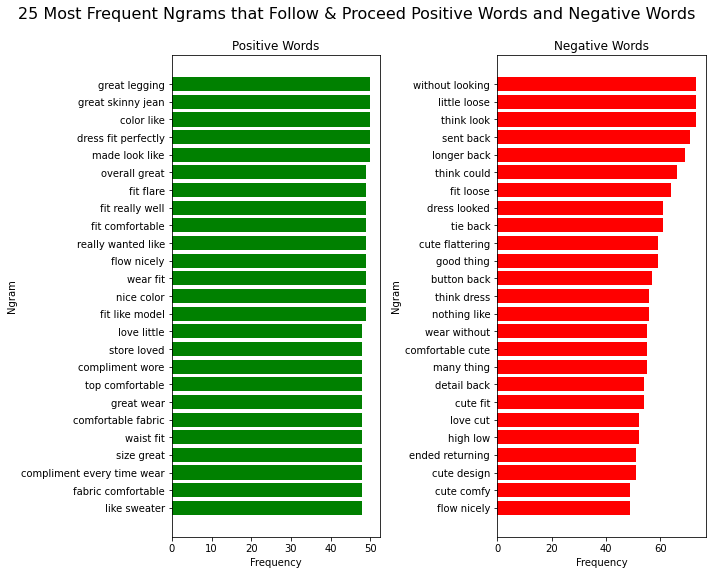

In [23]:
X = df.clean_review_text
vectorizer = CountVectorizer(max_features = 1000, ngram_range = (2,5))
DTM = vectorizer.fit_transform(X)
frequencies = sum(DTM).toarray()[0]
ngrams = pd.DataFrame(frequencies, index = vectorizer.get_feature_names(), columns = ['Frequency'])
ngrams.sort_values('Frequency', ascending = True, inplace=True)
ngrams = ngrams.reset_index().rename(columns={'index':'Term'})

# Filter ngrams to only those that include words that predict positive or negative sentiment
terms = list(ngrams.Term)
pos_terms = [s for s in terms if any(x in s for x in pos)]
neg_terms = [s for s in terms if any(x in s for x in neg)]

pos_ngrams = ngrams[ngrams.Term.isin(pos_terms)].head(25)
neg_ngrams = ngrams[ngrams.Term.isin(neg_terms)].head(25)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
ax1.barh(pos_ngrams.Term, pos_ngrams.Frequency, color='green')
# ax1.set_title('Positive Words:\n25 Most Frequent Ngrams that Follow & Proceed')
ax1.set_title('Positive Words')

ax2.barh(neg_ngrams.Term, neg_ngrams.Frequency, color='red')
# ax2.set_title('Negative Words:\n25 Most Frequent Ngrams that Follow & Proceed')
ax2.set_title('Negative Words')

for ax in [ax1, ax2]:
    ax.set(xlabel='Frequency', ylabel='Ngram')

plt.suptitle('25 Most Frequent Ngrams that Follow & Proceed Positive Words and Negative Words', fontsize=16, verticalalignment='center', horizontalalignment='center')
plt.tight_layout()
plt.show()

## Topic modeling
Separate reviews that recommend and don't recommend the product, and use Latent Dirichlet allocation (LDA) to identify topics in the reviews.

In [24]:
# Topics in reviews that recommend the product
pos = df[df['Recommended IND'] == 1]

text_clean = []
for text in pos['clean_review_text']:
    text_clean.append(text.split())

dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]

Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=5, id2word = dictionary, passes=30)

topics = ldamodel.top_topics(text_term_matrix, topn=10)
pos_topics_df = pd.DataFrame()
for x in range(len(topics)):
    pos_topics_df['Topic_' + str(x)] = dict(topics[x][0]).values()

pos_topics_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,love,dress,size,dress,color
1,great,fabric,small,love,online
2,color,like,fit,fit,store
3,top,look,top,size,one
4,wear,skirt,large,wear,person
5,sweater,fit,run,pant,blue
6,soft,flattering,ordered,jean,much
7,look,waist,medium,perfect,saw
8,fit,love,would,great,look
9,perfect,bit,x,compliment,picture


In [25]:
# Topics in reviews that do not recommend the product
neg = df[df['Recommended IND'] == 0]

text_clean = []
for text in neg['clean_review_text']:
    text_clean.append(text.split())


dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]

Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=5, id2word = dictionary, passes=30)

topics = ldamodel.top_topics(text_term_matrix, topn=10)
neg_topics_df = pd.DataFrame()
for x in range(len(topics)):
    neg_topics_df['Topic_' + str(x)] = dict(topics[x][0]).values()

neg_topics_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,top,like,dress,skirt,shirt
1,fit,dress,size,fabric,top
2,small,look,would,look,like
3,size,fabric,like,jean,would
4,look,love,color,design,white
5,dress,much,fabric,back,wear
6,would,color,back,material,color
7,ordered,would,fit,like,sweater
8,really,way,price,also,sheer
9,large,wanted,quality,color,ordered


# Classification model for product recommendation
Fit a classification model for product recommendation, and try different features, paramters, models, etc. to see which combination produces the best classification score.

In [26]:
def binary_classification(term_features = df.clean_review_text
                         , other_features = None
                         , target = df['Recommended IND']
                         , word_embedding = TfidfVectorizer
                         , ngram_range = (1, 1)
                         , max_term_features = 300
                         , model = LogisticRegression
                         , balance_classes = True
                         , score = f1_score):
    """Returns the score of a binary classification model."""
    if balance_classes:
        together = pd.concat([target, term_features, other_features], axis=1)
        
        class_zero = together[together[target.name] == 0]
        len_zero = len(class_zero)
        
        class_one = together[together[target.name] == 1]
        len_one = len(class_one)
        
        marjority_class = max(len_zero, len_one)
        
        if marjority_class == len_zero:
            down_sample = class_zero.sample(len_one)
            X_y = pd.concat([down_sample, class_one])
        else:
            down_sample = class_one.sample(len_zero)
            X_y = pd.concat([down_sample, class_zero])
            
    else:
        X_y = pd.concat([target, term_features, other_features], axis=1)
    
    terms = X_y[term_features.name]
    vectorizer = word_embedding(ngram_range = ngram_range, max_features = max_term_features)
    X_terms = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(terms), index=terms.index, columns=vectorizer.get_feature_names())
    
    if other_features is None:
        X = X_terms
    else:
        X = pd.concat([X_terms, X_y[other_features.name]], axis=1)
    
    y = X_y[target.name]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    try:
        clf = model(random_state=1).fit(X_train, y_train)
    except:
        try:
            clf = model().fit(DenseTransformer(X_train), y_train)
        except:
            try:
                clf = model().fit(X_train, y_train)
            except:
                pass
    
    y_pred = clf.predict(X_test)
    
    model_score = score(y_test, y_pred)
    print(model_score)

In [27]:
# Default parameters -- 
# Text predictors: review text
# Other predictors: none
# Word embedding: tf-idf
# Ngram range: (1, 1)
# Max term features: 300
# Classification model: logistic regression
# Balance classes: true
# Score: F1 score
binary_classification()

0.8090646094503375


In [28]:
# Add age as a predictor
binary_classification(other_features = df['Age'])

0.8047732696897375


In [29]:
# Add sentiment as a predictor
binary_classification(other_features = df['Sentiment'])

0.8218009478672985


In [30]:
# Longer length of ngrams (1,2)
binary_classification(ngram_range=(1,2))

0.8108623153882802


In [31]:
# Longer length of ngrams (1,3)
binary_classification(ngram_range=(1,3))

0.818957345971564


In [32]:
# Wider term matrix (max_term_features = 500)
binary_classification(max_term_features = 500)

0.8416075650118202


In [33]:
# Wider term matrix (max_term_features = 1000)
binary_classification(max_term_features = 1000)

0.8512673362027737


In [34]:
# Count vectorizer
binary_classification(word_embedding=CountVectorizer)

0.8059132093466856


In [35]:
# Allow for class imbalance
binary_classification(balance_classes=False)

0.923076923076923


In [36]:
# Allow for class imbalance and wider term matrix (max_term_features = 1000)
binary_classification(balance_classes=False, max_term_features = 1000)

0.9307050186060545


In [37]:
# Decision tree classifier
binary_classification(model=DecisionTreeClassifier)

0.6900141978230004


In [38]:
# Complement naive bayes
binary_classification(model=ComplementNB)

0.8116222760290557


#### The biggest improvements in the classification score come from allowing for class imbalance and having a wider term matrix

## Final model
Fit a classification model with the paramters that produced the best score, and see which features have the most predictive power.

In [39]:
# Create word embedding (tf-idf)
terms = df['clean_review_text']
vectorizer = TfidfVectorizer(ngram_range = (1, 1), max_features = 1000)
X = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(terms), index=terms.index, columns=vectorizer.get_feature_names())

# Separate target variable
y = df['Recommended IND']

# Separate train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Fit model and make a prediction
clf = LogisticRegression(random_state=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Score the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.52      0.62      1065
           1       0.90      0.96      0.93      4807

    accuracy                           0.88      5872
   macro avg       0.83      0.74      0.77      5872
weighted avg       0.87      0.88      0.87      5872



In [40]:
# Store model coefficients in a dataframe
rec_params = pd.DataFrame({'Feature': X.columns
                     , 'Logit': clf.coef_[0]})

# Convert coefficients from log odds (logit) to probability
rec_params['Probability'] = rec_params['Logit'].apply(logit_to_prob)

# Sort and separate terms with the highest and lowest probabilities
rec_params.sort_values('Probability', ascending=False, inplace=True)
pos_rec = list(rec_params.head(20).iloc[:,0])
neg_rec = list(rec_params.tail(20).iloc[:,0])

print('Terms that predict the product being recommended:')
print(pos_rec)
print('='*100)
print('Terms that predict the product NOT being recommended:')
print(neg_rec)

Terms that predict the product being recommended:
['perfect', 'love', 'comfortable', 'great', 'compliment', 'little', 'unique', 'perfectly', 'dd', 'bit', 'soft', 'comfy', 'amazing', 'happy', 'nicely', 'glad', 'order', 'dressed', 'beautifully', 'fun']
Terms that predict the product NOT being recommended:
['fabric', 'odd', 'unfortunately', 'would', 'idea', 'looked', 'seemed', 'bad', 'return', 'back', 'excited', 'huge', 'poor', 'awful', 'unflattering', 'returning', 'cheap', 'returned', 'wanted', 'disappointed']


In [41]:
end = datetime.now()
print('Duration:', end - start)

Duration: 0:07:17.723753
